In [7]:
import re
import time
import pandas as pd
import xarray as xr
from numpy import ones
from numpy.linalg import cholesky
from pandas_plink import read_plink1_bin
from limix.qc import quantile_gaussianize

In [247]:
import cellregmap
cellregmap 

<module 'cellregmap' from '/hps/nobackup/stegle/users/acuomo/git_repos/CellRegMap/cellregmap/__init__.py'>

In [248]:
from cellregmap import CellRegMap, run_interaction

In [5]:
revision_folder = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

In [250]:
# run 10 tests per job

In [251]:
input_files_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/new/input_files/"

In [252]:
## sample mapping file
## this file will map cells to donors 
## it will also only include donors we have single-cell data for (a subset of all of HipSci donors)
sample_mapping_file = input_files_dir+"sample_mapping_file.csv"
sample_mapping = pd.read_csv(sample_mapping_file, dtype={"genotype_individual_id": str, "phenotype_sample_id": str})

In [253]:
## genotype_individual_id are donor IDs, as found in the genotype matrix (G) and GRM covariance (K)
## phenotype_sample_id are cell IDs, as found in the scRNA-seq phenotype vector (y) and cell context covariance (C)
sample_mapping.head()

,genotype_individual_id,phenotype_sample_id
0,HPSI0114i-joxm_1,21843_1#10
1,HPSI0314i-fafq_1,21843_1#100
2,HPSI0314i-fafq_1,21843_1#101
3,HPSI1013i-wuye_2,21843_1#102
4,HPSI0114i-joxm_1,21843_1#103


In [254]:
## extract unique individuals
donors = sample_mapping["genotype_individual_id"].unique()
donors.sort()
print("Number of unique donors: {}".format(len(donors)))

Number of unique donors: 126


In [255]:
############################################
################ Kinship matrix ############
############################################

In [256]:
## read in GRM (genotype relationship matrix; kinship matrix)
kinship_folder="/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink-F/"
kinship_file=kinship_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.kinship"
K = pd.read_csv(kinship_file, sep="\t", index_col=0)
assert all(K.columns == K.index) #symmetric matrix, donors x donors

In [257]:
K = xr.DataArray(K.values, dims=["sample_0", "sample_1"], coords={"sample_0": K.columns, "sample_1": K.index})
K = K.sortby("sample_0").sortby("sample_1")
donors = sorted(set(list(K.sample_0.values)).intersection(donors))
print("Number of donors after kinship intersection: {}".format(len(donors)))

Number of donors after kinship intersection: 125


In [258]:
## subset to relevant donors
K = K.sel(sample_0=donors, sample_1=donors)
assert all(K.sample_0 == donors)
assert all(K.sample_1 == donors)

In [259]:
## and decompose such as K = hK @ hK.T (using Cholesky decomposition)
hK = cholesky(K.values)
hK = xr.DataArray(hK, dims=["sample", "col"], coords={"sample": K.sample_0.values})
assert all(hK.sample.values == K.sample_0.values)

In [260]:
del K
print("Sample mapping number of rows BEFORE intersection: {}".format(sample_mapping.shape[0]))
## subsample sample mapping file to donors in the kinship matrix
sample_mapping = sample_mapping[sample_mapping["genotype_individual_id"].isin(donors)]
print("Sample mapping number of rows AFTER intersection: {}".format(sample_mapping.shape[0]))

Sample mapping number of rows BEFORE intersection: 34256
Sample mapping number of rows AFTER intersection: 33964


In [261]:
############################################
##### expand from donors to cells ##########

In [262]:
## use sel from xarray to expand hK (using the sample mapping file)
hK_expanded = hK.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == sample_mapping["genotype_individual_id"].values)

In [263]:
######################################
############### Genotypes ############
######################################

In [264]:
## read in genotype file (plink format)
plink_folder = "/hps/nobackup/hipsci/scratch/genotypes/imputed/2017-03-27/Full_Filtered_SNPs_Plink/"
plink_file = plink_folder+"hipsci.wec.gtarray.HumanCoreExome.imputed_phased.20170327.genotypes.norm.renamed.bed"
G = read_plink1_bin(plink_file)

Mapping files: 100%|██████████| 3/3 [06:59<00:00, 139.79s/it]


In [265]:
#############################
###### SNP selection

In [ ]:
# filter file (columns: snp_id, gene)
fvf_filename = revision_folder+"/CRM_interaction_chr22/fvf.csv"
fvf = pd.read_csv(fvf_filename, index_col = 0)
fvf.head(20)

In [208]:
i = 204
genes = fvf['feature'].unique()
gene = genes[i]
gene

'ENSG00000100418_DESI1'

In [3]:
fvf_gene = fvf[fvf['feature']==gene]

NameError: name 'fvf' is not defined

In [270]:
n = fvf_gene.shape[0]
n

686

In [271]:
# for i in range(0,n,10):
#     print(i)

In [272]:
j = 0

In [273]:
fvf_sel = fvf_gene.iloc[j:(j+10)]
fvf_sel

,feature,snpID,chrom
735,ENSG00000100243_CYB5R3,22_42914931_T_C,22
736,ENSG00000100243_CYB5R3,22_42914937_A_G,22
737,ENSG00000100243_CYB5R3,22_42914974_T_C,22
738,ENSG00000100243_CYB5R3,22_42915479_G_A,22
739,ENSG00000100243_CYB5R3,22_42916215_C_G,22
740,ENSG00000100243_CYB5R3,22_42917154_C_T,22
741,ENSG00000100243_CYB5R3,22_42917813_C_T,22
742,ENSG00000100243_CYB5R3,22_42918859_A_G,22
743,ENSG00000100243_CYB5R3,22_42919010_C_T,22
744,ENSG00000100243_CYB5R3,22_42919125_C_T,22


In [274]:
genes = fvf_sel['feature'].unique()

In [275]:
genes

array(['ENSG00000100243_CYB5R3'], dtype=object)

In [276]:
# (1) gene name (feature_id)
gene_name = genes[0]
trait_name = re.sub("_.*","",gene_name)
trait_name

'ENSG00000100243'

In [277]:
leads = fvf_sel[fvf_sel['feature']==gene_name]['snpID'].unique()

In [278]:
G_sel = G[:,G['snp'].isin(leads)]

In [279]:
G_sel.shape

(1610, 10)

In [280]:
seed = 0

In [281]:
import numpy as np

In [282]:
#### to permute G, create shuffled index
# step 1 - shuffle G across donors (prior to expanding)
# step 2 - expand normally
# this is such as all cells from a given donor will keep the same genotype, but it will be that from another donor

random = np.random.RandomState(int(seed))
idx = random.permutation(G_sel.shape[0])
Idx = xr.DataArray(idx, dims=["sample"], coords = {"sample": G_sel.sample.values})
idx_G = Idx.sel(sample=sample_mapping["genotype_individual_id"].values)

In [283]:
############################################
##### expand from donors to cells ##########

In [284]:
# expand out genotypes from cells to donors (and select relevant donors in the same step)
G_expanded = G_sel.sel(sample=sample_mapping["genotype_individual_id"].values)
assert all(hK_expanded.sample.values == G_expanded.sample.values)

/nfs/software/stegle/users/acuomo/conda-envs/struct-lmm2/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 2383 times more chunks
  return self.array[key]


In [285]:
G_expanded.shape

(33964, 10)

In [286]:
######################################
############## Phenotypes ############
######################################

In [287]:
# Phenotype (single-cell expression)
phenotype_file = input_files_dir+"phenotype.csv.pkl"
phenotype = pd.read_pickle(phenotype_file)
print("Phenotype shape BEFORE selection: {}".format(phenotype.shape))
phenotype = xr.DataArray(phenotype.values, dims=["trait", "cell"], coords={"trait": phenotype.index.values, "cell": phenotype.columns.values})
phenotype = phenotype.sel(cell=sample_mapping["phenotype_sample_id"].values)
print("Phenotype shape AFTER selection: {}".format(phenotype.shape))
assert all(phenotype.cell.values == sample_mapping["phenotype_sample_id"].values)

Phenotype shape BEFORE selection: (11231, 34256)
Phenotype shape AFTER selection: (11231, 33964)


In [288]:
# select gene
y = phenotype.sel(trait=gene_name)
# quantile normalise
y = quantile_gaussianize(y)

In [289]:
######################################
########## Cell contexts #############
######################################

In [290]:
# cells by MOFA factors (20)
C_file = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/mofa_logcounts_model_factors.csv"
C = pd.read_csv(C_file, index_col = 0)
C = xr.DataArray(C.values, dims=["cell", "pc"], coords={"cell": C.index.values, "pc": C.columns.values})
C = C.sel(cell=sample_mapping["phenotype_sample_id"].values)
assert all(C.cell.values == sample_mapping["phenotype_sample_id"].values)

In [291]:
# quantile normalise cell contexts
C_gauss = quantile_gaussianize(C)

In [292]:
######################################
############ Covariates ##############
######################################

In [293]:
n_cells = phenotype.shape[1]
W = ones((n_cells, 1))

In [294]:
y = y.values.reshape(y.shape[0],1)
y.shape

(33964, 1)

In [295]:
W

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [296]:
C.values[:,0:10].shape
C.values[:,0:10]

array([[-0.59770402,  1.0674358 ,  0.0564961 , ...,  0.01520844,
         0.29224277, -0.63273743],
       [ 0.23328472,  2.13788372,  0.64681148, ..., -0.37349156,
         1.78959325, -0.65923266],
       [-0.05471216,  1.78603081, -0.09962504, ...,  0.07594282,
         0.87996128,  0.6806354 ],
       ...,
       [-0.80078862,  0.93532776, -1.06457988, ..., -0.26132522,
         0.29988706, -0.34527378],
       [-0.65763778,  1.30469584, -0.52890777, ...,  0.07814063,
         0.53126179, -0.13242109],
       [-0.78633873,  1.4659787 , -0.61704333, ...,  0.28598122,
         0.43912266,  0.24403696]])

In [297]:
start_time = time.time()
GG = G_expanded.values
print("--- %s seconds ---" % (time.time() - start_time))

--- 317.9826719760895 seconds ---


In [298]:
GG.shape

(33964, 10)

In [299]:
GG

array([[0., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 2.],
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 1., 1.]], dtype=float32)

In [300]:
## test permutations

In [301]:
# from typing import Optional

from glimix_core.lmm import LMM
from numpy import (
    asarray,
#     atleast_1d,
#     atleast_2d,
    concatenate,
    inf,
#     linspace,
#     ones,
#     sqrt,
#     stack,
)
# from numpy.linalg import cholesky
from numpy_sugar import ddot
from numpy_sugar.linalg import economic_qs_linear, economic_svd
# from tqdm import tqdm

from cellregmap._math import PMat, QSCov, ScoreStatistic

In [302]:
### null model

In [303]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
# [U, S, _] = economic_svd(C.values[:,0:20])
[U, S, _] = economic_svd(C)
del _
us = U * S
Ls = [ddot(us[:,i], hK_expanded) for i in range(us.shape[1])]
del us

In [304]:
crm = CellRegMap(y=y, W=W, E=C_gauss.values[:,0:10], Ls=Ls)

In [305]:
crm._rho1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [306]:
### scan interactions

In [307]:
G = asarray(GG, float)

In [309]:
i=0
g = G[:, [i]]

In [310]:
X = concatenate((W, g), axis=1)

In [311]:
best = {"lml": -inf, "rho1": 0}

In [312]:
for rho1 in crm._rho1:
    # Σ = ρ₁𝙴𝙴ᵀ + (1-ρ₁)𝙺⊙E
    # cov(y₀) = 𝓋₁Σ + 𝓋₂I
    QS = crm._Sigma_qs[rho1]
    lmm = LMM(crm._y, X, QS, restricted=True)
    lmm.fit(verbose=False)

    if lmm.lml() > best["lml"]:
        best["lml"] = lmm.lml()
        best["rho1"] = rho1
        best["lmm"] = lmm           

In [313]:
lmm = best["lmm"]

In [314]:
lmm

In [315]:
Q0 = crm._Sigma_qs[best["rho1"]][0][0]
S0 = crm._Sigma_qs[best["rho1"]][1]

In [316]:
qscov = QSCov(
    Q0,
    S0,
    lmm.v0,  # 𝓋₁
    lmm.v1,  # 𝓋₂
)

In [317]:
P = PMat(qscov, X)

In [318]:
# use permuted index

In [319]:
gtest = g.ravel()[idx_G]

In [320]:
g

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]])

In [321]:
gtest

array([0., 0., 0., ..., 0., 0., 0.])

In [322]:
E0 = C_gauss.values[:,0:10]

In [323]:
ss = ScoreStatistic(P, qscov, ddot(gtest, E0))
Q = ss.statistic(crm._y)

In [324]:
from chiscore import davies_pvalue

In [325]:
pval, pinfo = davies_pvalue(Q, ss.matrix_for_dist_weights(), True)
pval

0.7549026346995376

In [326]:
pv = crm.scan_interaction(G=GG, idx_G = idx_G)[0]
pv

100%|██████████| 10/10 [53:39<00:00, 321.93s/it]


array([0.75490263, 0.75490263, 0.66332932, 0.75490263, 0.2714031 ,
       0.50592643, 0.75917819, 0.50592643, 0.41992576, 0.5493864 ])

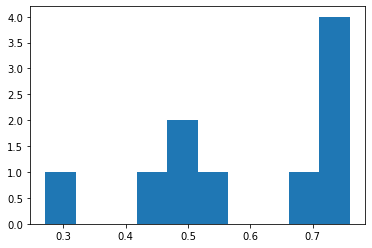

In [327]:
plt.hist(pv)
plt.show()

In [ ]:
#####

In [243]:
pval, pinfo = davies_pvalue(Q, ss.matrix_for_dist_weights(), True)
pval

0.20259700890235555

In [226]:
pval, pinfo = davies_pvalue(Q, ss.matrix_for_dist_weights(), True)
pval

0.24756271803677266

In [206]:
pval, pinfo = davies_pvalue(Q, ss.matrix_for_dist_weights(), True)
pval

0.202151045491757

In [244]:
# pv = crm.scan_interaction(G=GG, idx_G = idx_G)[0]
pv = [0.202151045491757, 0.24756271803677266, 0.20259700890235555]

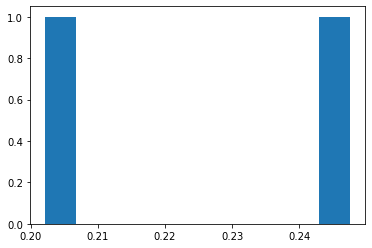

In [245]:
import matplotlib.pyplot as plt
plt.hist(pv)
plt.show()

In [ ]:
#####

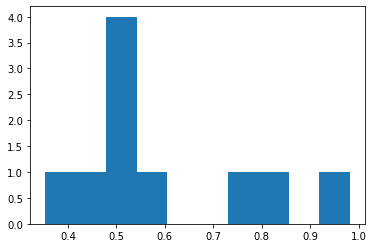

In [108]:
import matplotlib.pyplot as plt
plt.hist(pv)
plt.show()

In [48]:
# compare to pv=4.441206e-52 for both SNPs

In [49]:
from cellregmap import CellRegMap
from numpy_sugar.linalg import economic_svd
from numpy_sugar import ddot

In [50]:
# get decomposition of K*EEt 
# i.e. get Li's such that K*EEt = L1L1t + L2L2t + ..
# [U, S, _] = economic_svd(C.values[:,0:20])
[U, S, _] = economic_svd(C)
del _
us = U * S
Ls = [ddot(us[:,i], hK_expanded) for i in range(us.shape[1])]
del us

In [51]:
C.shape

(33964, 20)

In [52]:
start_time = time.time()
crm = CellRegMap(y=y, W=W, E=C_gauss.values[:,0:10], Ls=Ls)
pvals = crm.scan_interaction(GG)[0]
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 10/10 [50:32<00:00, 303.23s/it]

--- 3101.3919353485107 seconds ---


In [53]:
pv = pd.DataFrame({"chrom":G_expanded.chrom.values,
               "pv":pvals,
               "variant":G_expanded.snp.values})
pv.head()

,chrom,pv,variant
0,22,0.614792,22_38815543_G_T
1,22,0.679391,22_38815767_C_T
2,22,0.679953,22_38816059_T_C
3,22,0.472747,22_38816351_G_A
4,22,0.991658,22_38817047_A_G


In [54]:
start_time = time.time()
crm = CellRegMap(y=y, W=W, E=C_gauss.values[:,0:10], Ls=Ls)
pvals = run_interaction(y=y, W=W, E=C_gauss.values[:,0:10], G=GG, E2=C, hK=hK_expanded)[0]
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 10/10 [51:41<00:00, 310.12s/it]

--- 3247.722886323929 seconds ---


In [55]:
pv = pd.DataFrame({"chrom":G_expanded.chrom.values,
               "pv":pvals,
               "variant":G_expanded.snp.values})
pv.head()

,chrom,pv,variant
0,22,0.614792,22_38815543_G_T
1,22,0.679391,22_38815767_C_T
2,22,0.679953,22_38816059_T_C
3,22,0.472747,22_38816351_G_A
4,22,0.991658,22_38817047_A_G


In [56]:
start_time = time.time()
pvals = run_interaction(y, W=W, E=C_gauss.values[:,0:10], E1=C_gauss.values[:,0:10], E2=C.values[:,0:20], G=GG, hK=hK_expanded)[0]
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 10/10 [51:26<00:00, 308.65s/it]

--- 3158.3022513389587 seconds ---


In [57]:
pv = pd.DataFrame({"chrom":G_expanded.chrom.values,
               "pv":pvals,
               "variant":G_expanded.snp.values})
pv.head()

,chrom,pv,variant
0,22,0.614792,22_38815543_G_T
1,22,0.679391,22_38815767_C_T
2,22,0.679953,22_38816059_T_C
3,22,0.472747,22_38816351_G_A
4,22,0.991658,22_38817047_A_G


In [60]:
folder = revision_folder+"CRM_interaction_chr22/results/"
outfilename = f"{folder}{trait_name}_{i}.tsv"

In [61]:
outfilename

'/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/CRM_interaction_chr22/results/ENSG00000100206_0.tsv'

In [62]:
pv.to_csv(outfilename)